# Importando Bibliotecas

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import itertools

from scipy.stats import normaltest

import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from mlxtend.feature_selection import SequentialFeatureSelector

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import shap

import pickle

import warnings
warnings.filterwarnings('ignore')

# Funções

In [2]:
def normal_test(array, alpha=0.05):
    p = normaltest(array).pvalue
    if p < alpha:
        print(f'Rejeita H0. A distribuição NÃO está normalmente distribuída')
    else:
        print(f'Aceita H0. A distribuição está normalmente distribuída. P-valor = {p} >= {alpha}')

# Lendo os Dados

In [3]:
df = pd.read_csv('../Dados/df_final.csv')
df.head()

,data,vendas,vendas_Outra_Faculdade,vendas_PUCRIO,vendas_UFABC,vendas_UFF,vendas_UFMG,vendas_UFPE,vendas_UFRJ,vendas_UFSC,...,vendas_Outra_Cidade,vendas_Porto_Alegre,vendas_Recife,vendas_Rio_de_Janeiro,vendas_Salvador,vendas_Santo_Andre,vendas_Sao_Carlos,vendas_Sao_Paulo,trend,seasonal
0,2018-01-01,1819.00000,618.00000,100.00000,17.00000,194.00000,34.00000,71.00000,407.00000,23.00000,...,587.00000,11.00000,51.00000,521.00000,25.00000,9.00000,14.00000,187.00000,NaN,-2401.78443
1,2018-02-01,2012.00000,652.00000,98.00000,22.00000,199.00000,34.00000,85.00000,492.00000,28.00000,...,654.00000,11.00000,62.00000,592.00000,23.00000,13.00000,14.00000,205.00000,NaN,-1835.22888
2,2018-03-01,4035.00000,926.00000,229.00000,16.00000,357.00000,46.00000,163.00000,1473.00000,30.00000,...,1103.00000,14.00000,123.00000,1544.00000,22.00000,12.00000,29.00000,282.00000,NaN,935.86834
3,2018-04-01,4305.00000,1204.00000,189.00000,186.00000,512.00000,96.00000,134.00000,1098.00000,151.00000,...,1299.00000,21.00000,105.00000,1300.00000,38.00000,40.00000,27.00000,359.00000,NaN,670.79890
4,2018-05-01,3956.00000,1462.00000,176.00000,130.00000,349.00000,212.00000,158.00000,721.00000,122.00000,...,1250.00000,20.00000,110.00000,1065.00000,41.00000,39.00000,31.00000,300.00000,NaN,267.66001


---
# Time Series

In [4]:
tss = TimeSeriesSplit(n_splits=5)

## Prophet

In [5]:
df_prophet = df[['data', 'vendas']]
df_prophet.rename(columns={
    'data': 'ds',
    'vendas': 'y'
}, inplace=True)

In [6]:
df_prophet_treino, df_prophet_teste = train_test_split(df_prophet, train_size=0.75, shuffle=False)

In [7]:
train_sets = tss.split(df_prophet_treino)
cv = []

for i, (train, test) in enumerate(train_sets):
    df_train = df_prophet_treino.iloc[list(train)]
    df_test = df_prophet_treino.iloc[list(test)]
    m = Prophet().fit(df_train)
    forecast = m.predict(df_test)
    mape = metrics.mean_absolute_percentage_error(df_test['y'], forecast['yhat'])
    cv.append(mape)

cv = np.array(cv)
print(f'''Resultado por Cross-Validation: {cv.mean()*(100)} +/- {cv.std()*(100)}''')

10:54:38 - cmdstanpy - INFO - Chain [1] start processing
10:54:38 - cmdstanpy - INFO - Chain [1] done processing
10:54:39 - cmdstanpy - INFO - Chain [1] start processing
10:54:39 - cmdstanpy - INFO - Chain [1] done processing
10:54:39 - cmdstanpy - INFO - Chain [1] start processing
10:54:40 - cmdstanpy - INFO - Chain [1] done processing
10:54:40 - cmdstanpy - INFO - Chain [1] start processing
10:54:41 - cmdstanpy - INFO - Chain [1] done processing
10:54:41 - cmdstanpy - INFO - Chain [1] start processing
10:54:42 - cmdstanpy - INFO - Chain [1] done processing


Resultado por Cross-Validation: 28.143810008823454 +/- 7.971986910244578


In [8]:
model = Prophet().fit(df_prophet_treino)

10:54:42 - cmdstanpy - INFO - Chain [1] start processing
10:54:43 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
forecast = model.predict(df_prophet_teste)

mse = metrics.mean_squared_error(df_prophet_teste['y'], forecast['yhat'])
rmse = metrics.mean_squared_error(df_prophet_teste['y'], forecast['yhat'], squared=False)
mad = metrics.mean_absolute_error(df_prophet_teste['y'], forecast['yhat'])
mape = metrics.mean_absolute_percentage_error(df_prophet_teste['y'], forecast['yhat'])

print(f'''
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      EQM: 2432356.32
      REQM: 1559.6
      MAD: 1415.49
      MAPE: 13.46%
      


In [10]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto',x=forecast['ds'], y=forecast['yhat'], marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_prophet_teste['ds'], y=df_prophet_teste['y'], marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (Prophet)')
fig.show()

### Tuning

In [11]:
param_grid = {  
    'changepoint_prior_scale': [0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.1, 0.5, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
    }
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [12]:
mape_mean = []
mape_std = []

for params in all_params:
    train_sets = tss.split(df_prophet_treino)
    cv = []
    for i, (train, test) in enumerate(train_sets):
        df_train = df_prophet_treino.iloc[list(train)]
        df_test = df_prophet_treino.iloc[list(test)]
        m = Prophet(**params).fit(df_train)
        forecast = m.predict(df_test)
        mape = metrics.mean_absolute_percentage_error(df_test['y'], forecast['yhat'])
        cv.append(mape)
    cv = np.array(cv)
    mape_mean.append(cv.mean())
    mape_std.append(cv.std())

10:54:44 - cmdstanpy - INFO - Chain [1] start processing
10:54:44 - cmdstanpy - INFO - Chain [1] done processing
10:54:44 - cmdstanpy - INFO - Chain [1] start processing
10:54:44 - cmdstanpy - INFO - Chain [1] done processing
10:54:45 - cmdstanpy - INFO - Chain [1] start processing
10:54:45 - cmdstanpy - INFO - Chain [1] done processing
10:54:46 - cmdstanpy - INFO - Chain [1] start processing
10:54:46 - cmdstanpy - INFO - Chain [1] done processing
10:54:47 - cmdstanpy - INFO - Chain [1] start processing
10:54:47 - cmdstanpy - INFO - Chain [1] done processing
10:54:48 - cmdstanpy - INFO - Chain [1] start processing
10:54:48 - cmdstanpy - INFO - Chain [1] done processing
10:54:49 - cmdstanpy - INFO - Chain [1] start processing
10:54:49 - cmdstanpy - INFO - Chain [1] done processing
10:54:49 - cmdstanpy - INFO - Chain [1] start processing
10:54:49 - cmdstanpy - INFO - Chain [1] done processing
10:54:50 - cmdstanpy - INFO - Chain [1] start processing
10:54:50 - cmdstanpy - INFO - Chain [1]

In [13]:
tuning_results = pd.DataFrame(all_params)
tuning_results['mape_mean'] = mape_mean
tuning_results['mape_std'] = mape_std
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mape_mean,mape_std
0,0.10000,0.10000,additive,0.26527,0.09901
1,0.10000,0.10000,multiplicative,0.28786,0.10869
2,0.10000,0.50000,additive,0.28679,0.06966
3,0.10000,0.50000,multiplicative,0.31585,0.10794
4,0.10000,1.00000,additive,0.28423,0.07037
5,0.10000,1.00000,multiplicative,0.34067,0.11012
6,0.30000,0.10000,additive,0.25183,0.08477
7,0.30000,0.10000,multiplicative,0.25880,0.07890
8,0.30000,0.50000,additive,0.31661,0.06850
9,0.30000,0.50000,multiplicative,0.25049,0.08319


In [14]:
best_params = all_params[np.argmin(mape_mean)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


In [15]:
train_sets = tss.split(df_prophet_treino)
cv = []

for i, (train, test) in enumerate(train_sets):
    df_train = df_prophet_treino.iloc[list(train)]
    df_test = df_prophet_treino.iloc[list(test)]
    m = Prophet(**best_params).fit(df_train)
    forecast = m.predict(df_test)
    mape = metrics.mean_absolute_percentage_error(df_test['y'], forecast['yhat'])
    cv.append(mape)

cv = np.array(cv)
print(f'''Resultado por Cross-Validation com HiperParametros: {cv.mean()*(100)} +/- {cv.std()*(100)}''')

12:17:34 - cmdstanpy - INFO - Chain [1] start processing
12:17:34 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:36 - cmdstanpy - INFO - Chain [1] done processing
12:17:36 - cmdstanpy - INFO - Chain [1] start processing
12:17:53 - cmdstanpy - INFO - Chain [1] done processing
12:17:54 - cmdstanpy - INFO - Chain [1] start processing
12:18:15 - cmdstanpy - INFO - Chain [1] done processing


Resultado por Cross-Validation com HiperParametros: 23.99368006207796 +/- 6.906688001475714


### Modelo Final

In [16]:
model_tuned = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                      seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                      seasonality_mode=best_params['seasonality_mode'])

model_tuned.fit(df_prophet_treino)

12:18:16 - cmdstanpy - INFO - Chain [1] start processing
12:18:17 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
forecast_tuned = model_tuned.predict(df_prophet_teste)

mse = metrics.mean_squared_error(df_prophet_teste['y'], forecast_tuned['yhat'])
rmse = metrics.mean_squared_error(df_prophet_teste['y'], forecast_tuned['yhat'], squared=False)
mad = metrics.mean_absolute_error(df_prophet_teste['y'], forecast_tuned['yhat'])
mape = metrics.mean_absolute_percentage_error(df_prophet_teste['y'], forecast_tuned['yhat'])

print(f'''
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      EQM: 9463408.49
      REQM: 3076.27
      MAD: 2385.61
      MAPE: 24.17%
      


In [18]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto',x=forecast_tuned['ds'], y=forecast_tuned['yhat'], marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_prophet_teste['ds'], y=df_prophet_teste['y'], marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (Prophet)')
fig.show()

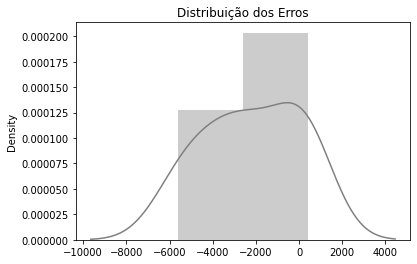

In [19]:
erro_prophet = df_prophet_teste['y'].values - forecast_tuned['yhat'].values
sns.distplot(erro_prophet, color='gray')
plt.title('Distribuição dos Erros')
plt.show()

In [20]:
normal_test(erro_prophet)

Aceita H0. A distribuição está normalmente distribuída. P-valor = 0.30028906255789695 >= 0.05


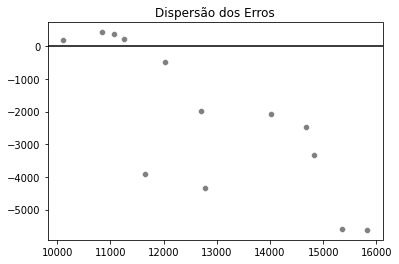

In [21]:
sns.scatterplot(forecast_tuned['yhat'].values, erro_prophet, color='gray')
plt.axhline(0, color='black')
plt.title('Dispersão dos Erros')
plt.show()

---
# Regressões

## Feature Engineering

### Criando LAGs

In [22]:
df_r = df.copy().drop(['vendas_Outra_Faculdade', 'vendas_Outra_Cidade', 'trend'], axis=1)
df_r.dropna(axis=0, inplace=True)
df_r.head()

,data,vendas,vendas_PUCRIO,vendas_UFABC,vendas_UFF,vendas_UFMG,vendas_UFPE,vendas_UFRJ,vendas_UFSC,vendas_UNICAMP,...,vendas_Natal,vendas_Niteroi,vendas_Porto_Alegre,vendas_Recife,vendas_Rio_de_Janeiro,vendas_Salvador,vendas_Santo_Andre,vendas_Sao_Carlos,vendas_Sao_Paulo,seasonal
0,2018-01-01,1819.00000,100.00000,17.00000,194.00000,34.00000,71.00000,407.00000,23.00000,200.00000,...,3.00000,79.00000,11.00000,51.00000,521.00000,25.00000,9.00000,14.00000,187.00000,-2401.78443
1,2018-02-01,2012.00000,98.00000,22.00000,199.00000,34.00000,85.00000,492.00000,28.00000,219.00000,...,2.00000,81.00000,11.00000,62.00000,592.00000,23.00000,13.00000,14.00000,205.00000,-1835.22888
2,2018-03-01,4035.00000,229.00000,16.00000,357.00000,46.00000,163.00000,1473.00000,30.00000,577.00000,...,9.00000,171.00000,14.00000,123.00000,1544.00000,22.00000,12.00000,29.00000,282.00000,935.86834
3,2018-04-01,4305.00000,189.00000,186.00000,512.00000,96.00000,134.00000,1098.00000,151.00000,434.00000,...,4.00000,232.00000,21.00000,105.00000,1300.00000,38.00000,40.00000,27.00000,359.00000,670.79890
4,2018-05-01,3956.00000,176.00000,130.00000,349.00000,212.00000,158.00000,721.00000,122.00000,376.00000,...,8.00000,155.00000,20.00000,110.00000,1065.00000,41.00000,39.00000,31.00000,300.00000,267.66001


In [23]:
lag_columns = ['vendas_PUCRIO', 'vendas_UFABC', 'vendas_UFF', 'vendas_UFMG', 'vendas_UFPE', 'vendas_UFRJ', 'vendas_UFSC', 'vendas_UNICAMP', 'vendas_USP', 'vendas_UTFPR', 'vendas_Belo_Horizonte',
       'vendas_Brasilia', 'vendas_Campinas', 'vendas_Campo_Grande',
       'vendas_Curitiba', 'vendas_Florianopolis', 'vendas_Fortaleza',
       'vendas_Goiania', 'vendas_Joinville', 'vendas_Juiz_de_Fora',
       'vendas_Manaus', 'vendas_Natal', 'vendas_Niteroi',
       'vendas_Porto_Alegre', 'vendas_Recife', 'vendas_Rio_de_Janeiro',
       'vendas_Salvador', 'vendas_Santo_Andre', 'vendas_Sao_Carlos',
       'vendas_Sao_Paulo']

In [24]:
for column in lag_columns:
    for lag in range(1, 4):
        novo_nome = f'{column}_LAG_{lag}'
        df_r[novo_nome] = df_r[column].shift(periods=lag, fill_value=0)

In [25]:
lag_columns_2 = ['vendas', 'seasonal']

In [26]:
for column in lag_columns_2:
    for lag in range(3, 13):
        novo_nome = f'{column}_LAG_{lag}'
        df_r[novo_nome] = df_r[column].shift(periods=lag, fill_value=0)

In [27]:
df_r.drop(lag_columns, axis=1, inplace=True)
df_r.drop('seasonal', axis=1, inplace=True)
df_r.head()

,data,vendas,vendas_PUCRIO_LAG_1,vendas_PUCRIO_LAG_2,vendas_PUCRIO_LAG_3,vendas_UFABC_LAG_1,vendas_UFABC_LAG_2,vendas_UFABC_LAG_3,vendas_UFF_LAG_1,vendas_UFF_LAG_2,...,seasonal_LAG_3,seasonal_LAG_4,seasonal_LAG_5,seasonal_LAG_6,seasonal_LAG_7,seasonal_LAG_8,seasonal_LAG_9,seasonal_LAG_10,seasonal_LAG_11,seasonal_LAG_12
0,2018-01-01,1819.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,2018-02-01,2012.00000,100.00000,0.00000,0.00000,17.00000,0.00000,0.00000,194.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,2018-03-01,4035.00000,98.00000,100.00000,0.00000,22.00000,17.00000,0.00000,199.00000,194.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,2018-04-01,4305.00000,229.00000,98.00000,100.00000,16.00000,22.00000,17.00000,357.00000,199.00000,...,-2401.78443,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,2018-05-01,3956.00000,189.00000,229.00000,98.00000,186.00000,16.00000,22.00000,512.00000,357.00000,...,-1835.22888,-2401.78443,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


### Criando Dummies - Mês

In [28]:
df_r['mes'] = pd.to_datetime(df_r['data']).dt.month_name()
df_r.head()

,data,vendas,vendas_PUCRIO_LAG_1,vendas_PUCRIO_LAG_2,vendas_PUCRIO_LAG_3,vendas_UFABC_LAG_1,vendas_UFABC_LAG_2,vendas_UFABC_LAG_3,vendas_UFF_LAG_1,vendas_UFF_LAG_2,...,seasonal_LAG_4,seasonal_LAG_5,seasonal_LAG_6,seasonal_LAG_7,seasonal_LAG_8,seasonal_LAG_9,seasonal_LAG_10,seasonal_LAG_11,seasonal_LAG_12,mes
0,2018-01-01,1819.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,January
1,2018-02-01,2012.00000,100.00000,0.00000,0.00000,17.00000,0.00000,0.00000,194.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,February
2,2018-03-01,4035.00000,98.00000,100.00000,0.00000,22.00000,17.00000,0.00000,199.00000,194.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,March
3,2018-04-01,4305.00000,229.00000,98.00000,100.00000,16.00000,22.00000,17.00000,357.00000,199.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,April
4,2018-05-01,3956.00000,189.00000,229.00000,98.00000,186.00000,16.00000,22.00000,512.00000,357.00000,...,-2401.78443,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,May


In [29]:
df_r = pd.get_dummies(df_r, columns=['mes'])
df_r.head()

,data,vendas,vendas_PUCRIO_LAG_1,vendas_PUCRIO_LAG_2,vendas_PUCRIO_LAG_3,vendas_UFABC_LAG_1,vendas_UFABC_LAG_2,vendas_UFABC_LAG_3,vendas_UFF_LAG_1,vendas_UFF_LAG_2,...,mes_December,mes_February,mes_January,mes_July,mes_June,mes_March,mes_May,mes_November,mes_October,mes_September
0,2018-01-01,1819.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,1,0,0,0,0,0,0,0
1,2018-02-01,2012.00000,100.00000,0.00000,0.00000,17.00000,0.00000,0.00000,194.00000,0.00000,...,0,1,0,0,0,0,0,0,0,0
2,2018-03-01,4035.00000,98.00000,100.00000,0.00000,22.00000,17.00000,0.00000,199.00000,194.00000,...,0,0,0,0,0,1,0,0,0,0
3,2018-04-01,4305.00000,229.00000,98.00000,100.00000,16.00000,22.00000,17.00000,357.00000,199.00000,...,0,0,0,0,0,0,0,0,0,0
4,2018-05-01,3956.00000,189.00000,229.00000,98.00000,186.00000,16.00000,22.00000,512.00000,357.00000,...,0,0,0,0,0,0,1,0,0,0


### Divisão entre Treino e Teste

In [30]:
df_r_treino, df_r_teste = train_test_split(df_r, train_size=0.75, shuffle=False)

In [31]:
X_r = df_r.drop(['data', 'vendas'], axis=1)
y_r = df_r['vendas']

In [32]:
X_r_treino, X_r_teste, y_r_treino, y_r_teste = train_test_split(X_r, y_r, train_size=0.75, shuffle=False)

## Modelos

In [33]:
modelos = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(), SVR(), AdaBoostRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(), RandomForestRegressor(), HistGradientBoostingRegressor(), LGBMRegressor(), CatBoostRegressor(verbose=False)]

In [34]:
modelos_score = []

for modelo in modelos:
    pipe = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', modelo)
    ])
    cv = cross_val_score(pipe, X_r_treino, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
    modelos_score.append({'modelo': modelo, 'mape': cv.mean()*(-100), 'std': cv.std()*(100)})

In [35]:
modelos_score = pd.DataFrame(modelos_score)
modelos_score.sort_values(by='mape', ascending=True, inplace=True)
modelos_score

,modelo,mape,std
8,RandomForestRegressor(),20.38678,5.76110
5,AdaBoostRegressor(),21.27739,6.20971
6,ExtraTreesRegressor(),21.91073,7.40849
7,GradientBoostingRegressor(),21.95187,7.44166
3,DecisionTreeRegressor(),22.50171,7.12169
1,Ridge(),23.14110,9.24965
11,<catboost.core.CatBoostRegressor object at 0x7...,23.72045,7.00143
0,LinearRegression(),24.34091,8.90464
2,Lasso(),29.57274,14.40513
9,HistGradientBoostingRegressor(),31.21862,6.02576


# Extra Trees Regressor

In [36]:
pipe_et = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', ExtraTreesRegressor())
])

In [37]:
cv = cross_val_score(pipe_et, X_r_treino, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
print(f'''Resultado por Cross-Validation: {cv.mean()*(-100)} +/- {cv.std()*(100)}''')

Resultado por Cross-Validation: 21.461865748052475 +/- 7.935109383556013


In [38]:
pipe_et.fit(X_r_treino, y_r_treino)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model', ExtraTreesRegressor())])

In [39]:
pred_teste_et = pipe_et.predict(X_r_teste)

mse = metrics.mean_squared_error(y_r_teste, pred_teste_et)
rmse = metrics.mean_squared_error(y_r_teste, pred_teste_et, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, pred_teste_et)
mape = metrics.mean_absolute_percentage_error(y_r_teste, pred_teste_et)

print(f'''
      ExtraTrees Regression Standard - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      ExtraTrees Regression Standard - Teste
      EQM: 5450366.45
      REQM: 2334.6
      MAD: 1995.13
      MAPE: 17.87%
      


In [40]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto', x=df_r_teste['data'], y=pred_teste_et, marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (ExtraTrees Regression)')
fig.show()

### Feature Selection

In [41]:
bfs = SequentialFeatureSelector(pipe_et, k_features='best', scoring='r2', cv=tss, forward=False)
bfs.fit(X_r_treino, y_r_treino)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=Pipeline(steps=[('preprocessor',
                                                     StandardScaler()),
                                                    ('model',
                                                     ExtraTreesRegressor())]),
                          forward=False, k_features='best', scoring='r2')

In [42]:
bfs_features = list(bfs.k_feature_names_)
bfs_features

['vendas_Porto_Alegre_LAG_1',
 'vendas_LAG_6',
 'seasonal_LAG_12',
 'mes_December',
 'mes_February',
 'mes_May']

In [43]:
cv_all = cross_val_score(pipe_et, X_r_treino, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
print(f'''Resultado por Cross-Validation usando todas as features: {cv_all.mean()*(-100)} +/- {cv_all.std()*(100)}''')

Resultado por Cross-Validation usando todas as features: 21.386115267041315 +/- 8.051415815784898


In [44]:
X_r_treino_bfs = X_r_treino.loc[:,bfs_features]
cv_bfs = cross_val_score(pipe_et, X_r_treino_bfs, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
print(f'''Resultado por Cross-Validation usando as "melhores" features: {cv_bfs.mean()*(-100)} +/- {cv_bfs.std()*(100)}''')

Resultado por Cross-Validation usando as "melhores" features: 17.537279932351247 +/- 4.422828407798742


### Tuning

In [45]:
params = {"model__max_depth": [None, 4, 8, 12, 16, 20],
          "model__min_samples_split": np.arange(2, 11),
          "model__min_samples_leaf": np.arange(1, 11),
          "model__n_estimators": np.arange(100,650,50)
          }

In [46]:
grid = GridSearchCV(pipe_et, param_grid=params, scoring='neg_mean_absolute_percentage_error', cv=tss, n_jobs=-1, verbose=1)
grid.fit(X_r_treino_bfs, y_r_treino)

Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('model', ExtraTreesRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 4, 8, 12, 16, 20],
                         'model__min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'model__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'model__n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [47]:
grid.best_params_

{'model__max_depth': 12,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 200}

### Modelo Final

In [48]:
pipe_et_tuned = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('model', ExtraTreesRegressor(max_depth=grid.best_params_['model__max_depth'],
                                  min_samples_leaf=grid.best_params_['model__min_samples_leaf'],
                                  min_samples_split=grid.best_params_['model__min_samples_split'],
                                  n_estimators=grid.best_params_['model__n_estimators']))
])

In [49]:
cv_bfs_tuned = cross_val_score(pipe_et_tuned, X_r_treino_bfs, y_r_treino, cv=tss, scoring='neg_mean_absolute_percentage_error')
print(f'''Resultado por Cross-Validation usando as "melhores" features e o HiperParametros: {cv_bfs_tuned.mean()*(-100)} +/- {cv_bfs_tuned.std()*(100)}''')

Resultado por Cross-Validation usando as "melhores" features e o HiperParametros: 17.73435973022221 +/- 4.239945977007947


In [50]:
pipe_et_tuned.fit(X_r_treino_bfs, y_r_treino)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('model', ExtraTreesRegressor(max_depth=12, n_estimators=200))])

In [51]:
X_r_teste_bfs = X_r_teste.loc[:,bfs_features]
pred_teste_et_tuned = pipe_et_tuned.predict(X_r_teste_bfs)

mse = metrics.mean_squared_error(y_r_teste, pred_teste_et_tuned)
rmse = metrics.mean_squared_error(y_r_teste, pred_teste_et_tuned, squared=False)
mad = metrics.mean_absolute_error(y_r_teste, pred_teste_et_tuned)
mape = metrics.mean_absolute_percentage_error(y_r_teste, pred_teste_et_tuned)

print(f'''
      ExtraTrees Regression Standard - Teste
      EQM: {round(mse,2)}
      REQM: {round(rmse,2)}
      MAD: {round(mad,2)}
      MAPE: {round(mape*100,2)}%
      ''')


      ExtraTrees Regression Standard - Teste
      EQM: 5698040.9
      REQM: 2387.06
      MAD: 1914.01
      MAPE: 17.38%
      


In [52]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto', x=df_r_teste['data'], y=pred_teste_et_tuned, marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto (ExtraTrees Regression)')
fig.show()

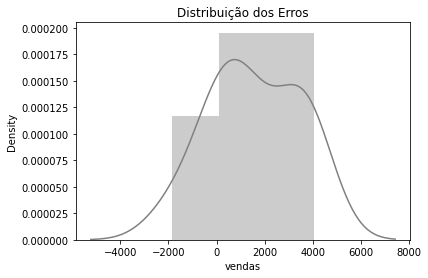

In [53]:
erro_et = y_r_teste - pred_teste_et_tuned
sns.distplot(erro_et, color='gray')
plt.title('Distribuição dos Erros')
plt.show()

In [54]:
normal_test(erro_et)

Aceita H0. A distribuição está normalmente distribuída. P-valor = 0.6272061297375948 >= 0.05


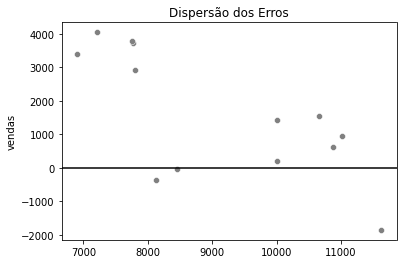

In [55]:
sns.scatterplot(pred_teste_et_tuned, erro_et, color='gray')
plt.axhline(0, color='black')
plt.title('Dispersão dos Erros')
plt.show()

# Plot dos Três Métodos

In [56]:
fig = go.Figure(data=[
    go.Scatter(name='Previsto Prophet',x=forecast_tuned['ds'], y=forecast_tuned['yhat'], marker={'color': 'green'}),
    go.Scatter(name='Previsto ExtraTrees', x=df_r_teste['data'], y=pred_teste_et_tuned, marker={'color': 'orange'}),
    go.Scatter(name='Real', x=df_r_teste['data'], y=y_r_teste, marker={'color': 'gray'})
    ])
fig.update_layout(font=dict(color='black'), title_text='Real vs. Previsto')
fig.show()

# Interpretação

### Feature Importance

In [57]:
feat_importances = pd.Series(pipe_et_tuned['model'].feature_importances_, index=X_r_treino_bfs.columns)

<AxesSubplot:title={'center':'Feature Importances'}>

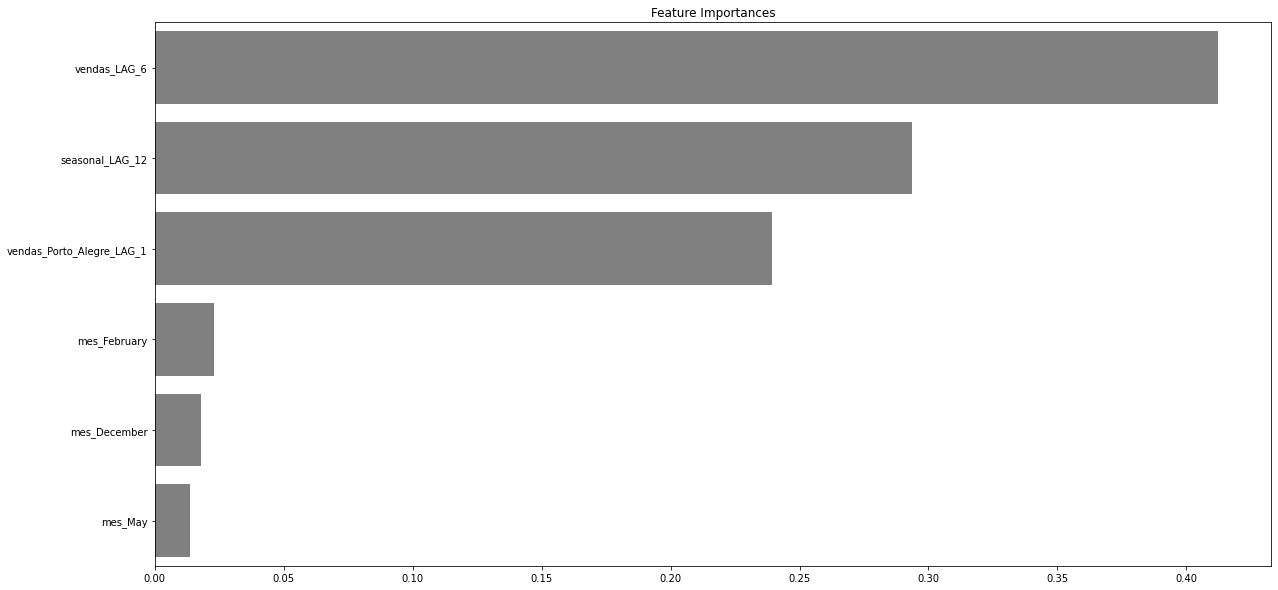

In [58]:
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
sns.barplot(x=feat_importances.nlargest(10), y=feat_importances.nlargest(10).index, orient='h', color='gray')

### Shap

In [59]:
shap.initjs()

In [60]:
explainer = shap.TreeExplainer(pipe_et_tuned['model'])
shap_values = explainer.shap_values(X_r_treino_bfs)

##### Summary Plot

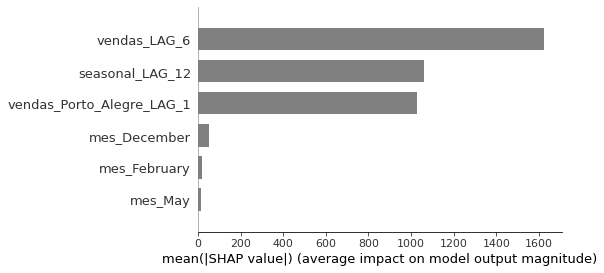

In [61]:
shap.summary_plot(shap_values, X_r_treino_bfs, plot_type='bar', color='gray')

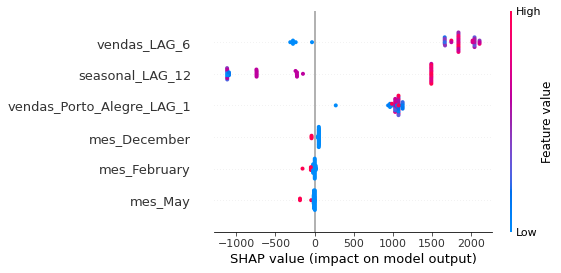

In [62]:
shap.summary_plot(shap_values, X_r_treino_bfs)

##### Dependence Plot

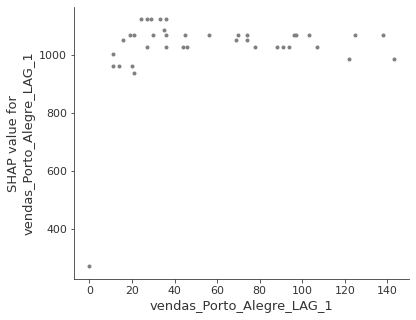

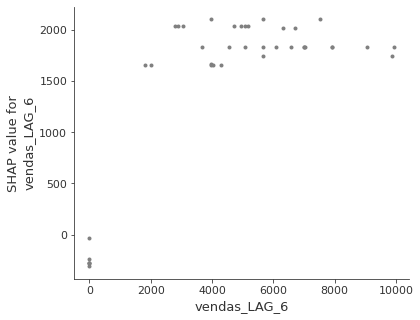

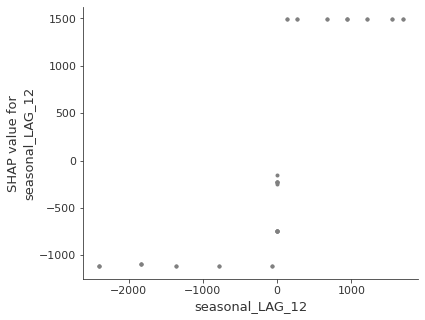

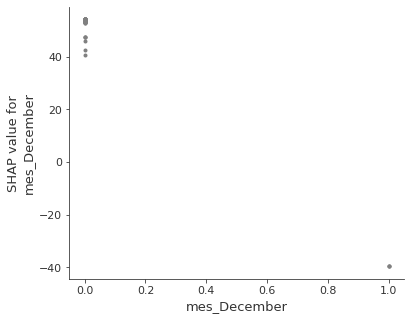

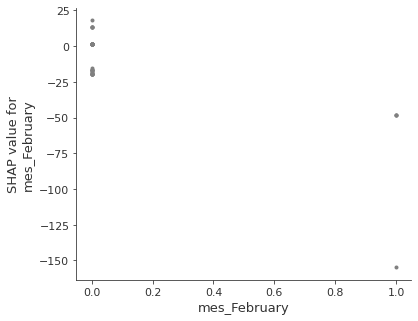

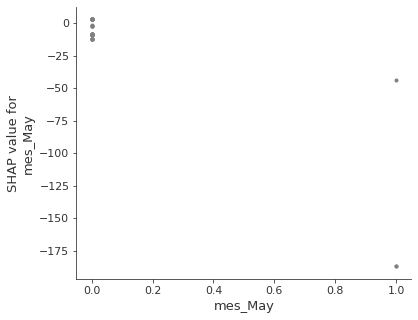

In [63]:
for column in X_r_treino_bfs.columns:
  shap.dependence_plot(column, shap_values, X_r_treino_bfs, interaction_index=None, color='gray')

##### Force Plot

In [64]:
shap.force_plot(explainer.expected_value, shap_values[38], X_r_treino_bfs.iloc[38,:])

# Exportando o modelo

In [65]:
pickle.dump(pipe_et_tuned, open('../Modelos/pipeline.pkl', 'wb'))